<b>Author</b>: Vladislav Krendelev (https://github.com/mega-tommy)

The following is the formulation and solution for <b>Exercise 1-7</b> from <i>Brunton, S., & Kutz, J. (2022). Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control (2nd ed.). Cambridge: Cambridge University Press. (doi:10.1017/9781009089517)</i>.<br>

<b>Exercise 1-7</b> Load the data set for fluid flow past a cylinder (you can either download this from our book http://DMDbook.com or generate it using the IBPM code on GitHub). Each column is a flow field that has been reshaped into a vector.

<ol style="list-style-type: lower-alpha">
<li>
Compute the SVD of this data set and plot the singular value spectrum and the leading singular vectors.<br>
The <b>U</b> matrix contains eigenflow fields and the <b>$\Sigma$V<sup>*</sup></b> represents the amplitudes of these eigenflows as the flow evolves in time.
</li>
    
<li>
Write a code to plot the reconstructed movie for various truncation values <i>r</i>. 
Compute the <i>r</i> value needed to capture 90%, 99%, and 99.9% of the flow energy based on the sigular value spectrum (recall that energy is given by the Frobenius norm squared). Plot the movies for each of these truncation values and compare the fidelity. Also compute the squared Frobenius norm of the error between the true matrix <b>X</b> and the reconstructed matrix <b>$\tilde{X}$</b>, where <b>X</b> is the flow field movie.
</li>
    
<li>
Fix a value <i>r</i> = 10 and compute the truncated SVD. <br>
Each column <b>w</b><sub><i>k</i></sub> of the matrix <b>W</b> = <b>$\tilde{\Sigma}\tilde{V}$<sup>*</sup></b> represents the mixture of the first 10 eigenflows in the <i>k</i>th column of <b>X</b>. Verify this by comparing the <i>k</i>th snapshot of <b>X</b> with <b>$\tilde{U}$w<sub><i>k</i></sub></b>.
</li>
    
<li>
Now, build a linear regression model for how the amplitudes <b>w</b><sub><i>k</i></sub> evolve in time. 
This will be a dynamical system: 
<center><b>w</b><sub><i>k+1</i></sub> = <b>Aw</b><sub><i>k</i></sub>.</center>
Create a matrix <b>W</b> with the first 1 through <i>m</i> - 1 columns of <b>$\Sigma$V<sup>*</sup></b> and another matrix <b>W</b>' with 2 through <i>m</i> columns of <b>$\Sigma$V<sup>*</sup></b>. We will now try to solve for a best-fit <b>A</b> matrix so that 
<center><b>W'</b> $\approx$ <b>AW</b>.</center>
Compute the SVD of <b>W</b> and use this to compute the pseudo-inverse of <b>W</b> to solve for <b>A</b>. Compute the eigenvalues of <b>A</b> and plot them in the complex plane.
</li>

<li>
Use this <b>A</b> matrix to advance the state 
<b>w</b><sub><i>k</i></sub> = A<sup><i>k</i>-1</sup><b>w</b><sub>1</sub> starting from <b>w</b><sub>1</sub>. Plot the reconstructed flow field using these predicted amplitude vectors and compare with the true values.
</li>
    
</ol>

In [1]:
import numpy as np
from scipy import io

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython import display
plt.rcParams['animation.ffmpeg_path'] = '../ffmpeg/bin/ffmpeg'

In [2]:
data = io.loadmat('VORTALL.mat')
X = data['VORTALL']

In [3]:
# function that takes a matrix A with flow fields as an input and returns its movie 

def flow_field_vizualization(A,cmap='jet',vmin=-1,vmax=1,interval=50,repeat_delay=1000):
    """
    A - (n x m) matrix/dataset;
    
    cmap - colormap name;
    
    vmin and vmax define the data range that the colormap covers
    (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html);
    
    The following arguments are arguments for matplotlib.animation.ArtistAnimation [sub]class
    (https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.ArtistAnimation.html):
    
    interval - delay between frames in milliseconds; 
    repeat_delay - delay in milliseconds between consecutive animation runs.

    """
    # number of columns (snapshots or flow fields) in the dataset
    m = A.shape[1]
    
    fig, ax = plt.subplots()
    ims = []
    
    for i in range(m):
        # reshape each flow field vector into a 449 x 199 matrix 
        s = np.real(np.reshape(A[:,i],(449,199)))
        # and then transpose it
        s = s.T
        im = ax.imshow(s,cmap=cmap,vmin=vmin,vmax=vmax,animated=True)
        if i==0:
            ax.imshow(s,cmap=cmap,vmin=vmin,vmax=vmax)
        ims.append([im])

    # plot the cylinder
    plt.scatter(49,99,2800,color='k')
    
    anim = animation.ArtistAnimation(fig,ims,interval=interval, blit=True, repeat_delay=repeat_delay)
    
    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()   

In [4]:
# vizualization of the given data set
flow_field_vizualization(X)

<ol style="list-style-type: lower-alpha">
<li>
Compute the SVD of this data set and plot the singular value spectrum and the leading singular vectors.<br>
The <b>U</b> matrix contains eigenflow fields and the <b>$\Sigma$V<sup>*</sup></b> represents the amplitudes of these eigenflows as the flow evolves in time.
</li>
</ol>
    
Source: <i>Brunton, S., & Kutz, J. (2022). Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control (2nd ed.). Cambridge: Cambridge University Press. (doi:10.1017/9781009089517)</i>

In [5]:
# SVD (We will consider only Economy SVD)  
Ue, Se, VTe = np.linalg.svd(X,full_matrices=False)

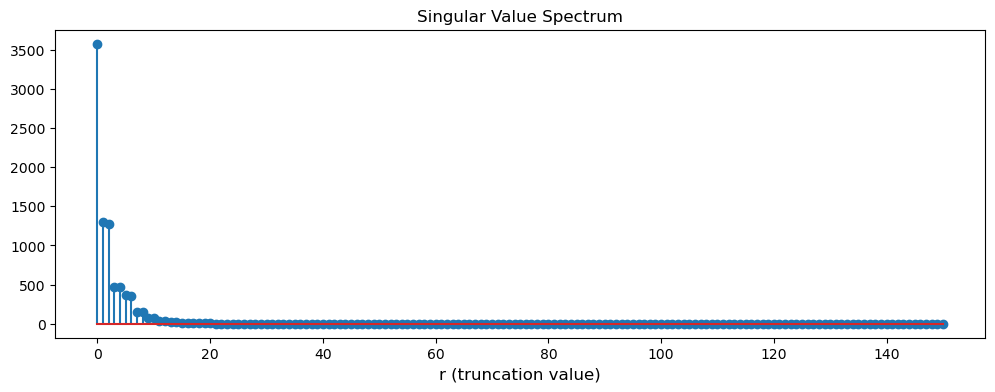

In [6]:
# Plot the singular value spectrum
plt.figure(figsize=(12,4))
plt.title('Singular Value Spectrum')
plt.stem(Se)
plt.xlabel('r (truncation value)',fontsize=12)
plt.show()

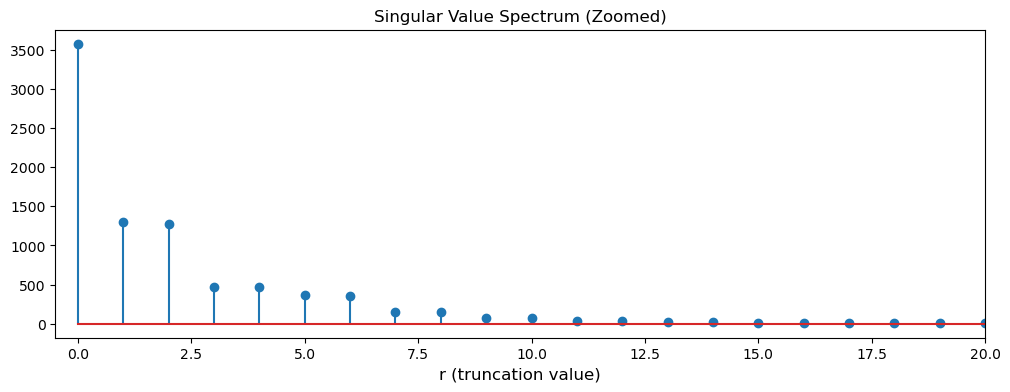

In [7]:
# Zoom in the sigular value spectrum
plt.figure(figsize=(12,4))
plt.title('Singular Value Spectrum (Zoomed)')
plt.stem(Se)
plt.xlim([-0.5,20])
plt.xlabel('r (truncation value)',fontsize=12)
plt.show()

From the graphs above it can be seen that the singular values  decrease fast - for <i>r</i> > 10, $\sigma$<sub><i>r</i></sub> are approximately zeros. That fact indicates that:
1. strong patterns present in the data;
2. the given matrix **X** can be approximated well* by keeping just first 10 singular values $\sigma$<sub><i>r</i></sub> in the decomposition.

\* - <i>we will later use Frobenius norm to quantify the quality of such the approximation.</i>   

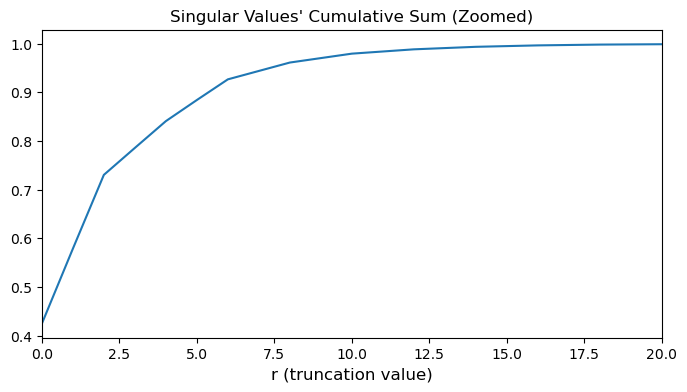

In [9]:
# Plot the cumulative sum of the singular values
cumsum = np.cumsum(Se)/np.sum(Se)

plt.figure(figsize=(8,4))
plt.title('Singular Values\' Cumulative Sum (Zoomed)')
plt.plot(cumsum)
plt.xlim([0,20])
plt.xlabel('r (truncation value)',fontsize=12)
plt.show()

The cumulative sum graph also reinforces the statement above demonstarting that the first 10 singular values $\sigma$<sub><i>r</i></sub> captures approximately 97% of the dynamics present in the system.    

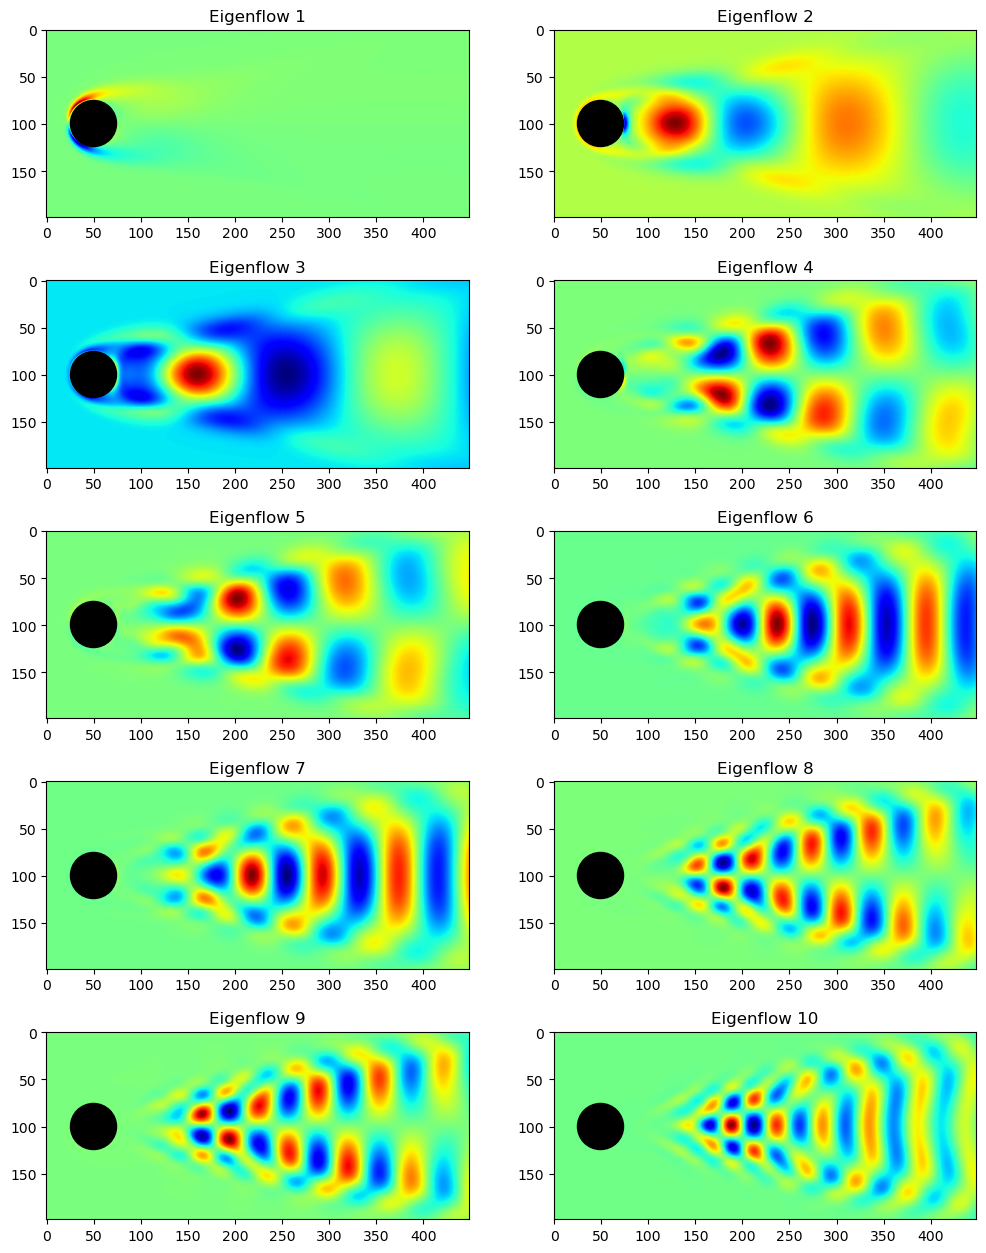

In [8]:
# plot the leading (i.e, first 10) singular vectors (or eigenflows from matrix U) 
fig = plt.figure(figsize=(12, 32))
for i in range(10):
    u = np.real(np.reshape(Ue[:,i],(449,199)))
    u = u.T
    ax = fig.add_subplot(10,2,i+1)
    ax = plt.imshow(u,cmap='jet')
    ax = plt.scatter(49,99,1100,color='k')
    plt.title(f'Eigenflow {i+1}')
plt.show()

<ol style="list-style-type: lower-alpha" start="2">
<li>
Write a code to plot the reconstructed movie for various truncation values <i>r</i>. 
Compute the <i>r</i> value needed to capture 90%, 99%, and 99.9% of the flow energy based on the sigular value spectrum (recall that energy is given by the Frobenius norm squared). Plot the movies for each of these truncation values and compare the fidelity. Also compute the squared Frobenius norm of the error between the true matrix <b>X</b> and the reconstructed matrix <b>$\tilde{X}$</b>, where <b>X</b> is the flow field movie.
</li>
</ol>

Source: <i>Brunton, S., & Kutz, J. (2022). Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control (2nd ed.). Cambridge: Cambridge University Press. (doi:10.1017/9781009089517)</i>

In [10]:
# Frobenius norm of a matrix A is essentially the 2-norm of the matrix A reshaped into a vector.
def Frobenius_norm(A):
    return np.sqrt(np.sum(A.flatten()**2))

In [11]:
def error(X,X_tilda):
    err = Frobenius_norm(X - X_tilda)**2 / Frobenius_norm(X)**2
    return np.round(err * 100, 2) 

In [13]:
# flow energy of the original system
energy_X = Frobenius_norm(X) ** 2

# dict that will contain "truncation value - approximated matrix X" pairs
Xs = {}
# energy values of the truncated matrices X_tr
energy_trs = []

# transform the vector with singular values to diagonal matrix 
Se_diag = np.diag(Se) 

# Based on the analysis performed above, we could safely expect that the truncation value r = 20
# will captures almost all of the energy in the original matrix.

for r in range(1,21):
    X_tr = Ue[0:,0:r] @ Se_diag[0:r,0:r] @ VTe[0:r,0:]
    Xs[r] = X_tr
    energy_trs.append(Frobenius_norm(X_tr)**2)
    
energy_trs = np.array(energy_trs)

# energy values of the truncated matrices in relation to the energy of the oroginal matrix
energy_pct =  np.round((energy_trs / energy_X),4) * 100
print(energy_pct)

[ 75.83  85.82  95.53  96.82  98.1   98.89  99.65  99.78  99.9   99.94
  99.98  99.98  99.99  99.99 100.   100.   100.   100.   100.   100.  ]


From the output above, we can see that r=2 captures 85.8% (the closest value to 90%) of the flow energy, 
r=6 - 98.9%, r=9 - 99.9%.

In [14]:
# Video for r=2
err = error(X,Xs[2])
print(f'The error between the original matrix X and the reconstructed matrix X_tilda: {err}%')
flow_field_vizualization(Xs[2])

The error between the original matrix X and the reconstructed matrix X_tilda: 14.18%


In [15]:
# Video for r=6
err = error(X,Xs[6])
print(f'The error between the original matrix X and the reconstructed matrix X_tilda: {err}%')
flow_field_vizualization(Xs[6])

The error between the original matrix X and the reconstructed matrix X_tilda: 1.11%


In [16]:
# Video for r=9
err = error(X,Xs[9])
print(f'The error between the original matrix X and the reconstructed matrix X_tilda: {err}%')
flow_field_vizualization(Xs[9])

The error between the original matrix X and the reconstructed matrix X_tilda: 0.1%


<ol style="list-style-type: lower-alpha" start="3">
<li>
Fix a value <i>r</i> = 10 and compute the truncated SVD. <br>
Each column <b>w</b><sub><i>k</i></sub> of the matrix <b>W</b> = <b>$\tilde{\Sigma}\tilde{V}$<sup>*</sup></b> represents the mixture of the first 10 eigenflows in the <i>k</i>th column of <b>X</b>. Verify this by comparing the <i>k</i>th snapshot of <b>X</b> with <b>$\tilde{U}$w<sub><i>k</i></sub></b>.
</li>
</ol>

Source: <i>Brunton, S., & Kutz, J. (2022). Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control (2nd ed.). Cambridge: Cambridge University Press. (doi:10.1017/9781009089517)</i>

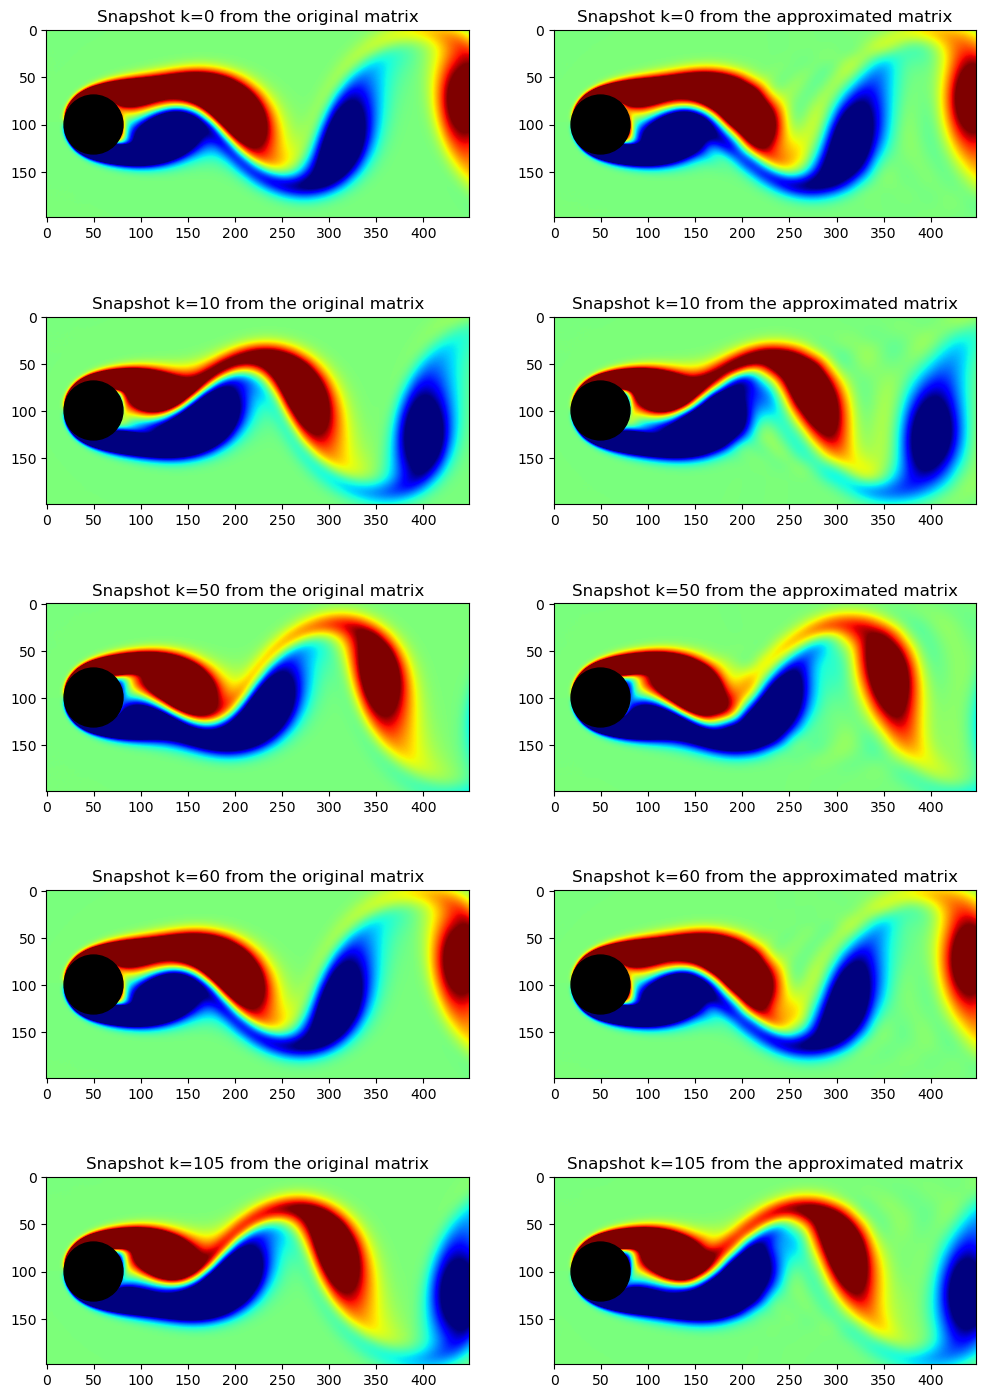

In [17]:
# The truncated SVD for r = 10 has already been calculated and is stored in the Xs dict. 
# Compare the snaphots for 5 arbitrarily chosen points. 

fig, ax = plt.subplots(5,2,figsize=(12, 18))
for i, k in enumerate([0,10,50,60,105]):
    x_k = np.real(np.reshape(X[:,k],(449,199)))
    x_k = x_k.T
    x_k_tilda = np.real(np.reshape(Xs[10][:,k],(449,199)))
    x_k_tilda = x_k_tilda.T
    ax[i][0].imshow(x_k,cmap='jet',vmin=-1,vmax=1)
    ax[i][0].scatter(49,99,1800,color='k')
    ax[i][0].set_title(f'Snapshot k={k} from the original matrix')
    ax[i][1].imshow(x_k_tilda,cmap='jet',vmin=-1,vmax=1)
    ax[i][1].scatter(49,99,1800,color='k')
    ax[i][1].set_title(f'Snapshot k={k} from the approximated matrix')

In the images above, we can see that qulitative similarity between the snapshots from the original matrix **X** and the $\tilde{X}$ (r = 10).

<ol style="list-style-type: lower-alpha" start="4">
<li>
Now, build a linear regression model for how the amplitudes <b>w</b><sub><i>k</i></sub> evolve in time. 
This will be a dynamical system: 
<center><b>w</b><sub><i>k+1</i></sub> = <b>Aw</b><sub><i>k</i></sub>.</center>
Create a matrix <b>W</b> with the first 1 through <i>m</i> - 1 columns of <b>$\Sigma$V<sup>*</sup></b> and another matrix <b>W</b>' with 2 through <i>m</i> columns of <b>$\Sigma$V<sup>*</sup></b>. We will now try to solve for a best-fit <b>A</b> matrix so that 
<center><b>W'</b> $\approx$ <b>AW</b>.</center>
Compute the SVD of <b>W</b> and use this to compute the pseudo-inverse of <b>W</b> to solve for <b>A</b>. Compute the eigenvalues of <b>A</b> and plot them in the complex plane.
</li>
</ol>

Source: <i>Brunton, S., & Kutz, J. (2022). Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control (2nd ed.). Cambridge: Cambridge University Press. (doi:10.1017/9781009089517)</i>

In [24]:
m = X.shape[1]

# transform the vector with singular values to diagonal matrix 
Se_diag = np.diag(Se) 

Ampl = Se_diag @ VTe

W = Ampl[0:,0:m-1].copy()
W_dash = Ampl[0:,1:m].copy()

# SVD of matrix W (we will consider only Economy SVD)  
Uw, Sw, VTw = np.linalg.svd(W,full_matrices=False)

A = W_dash @ VTw.T @ np.linalg.inv(np.diag(Sw)) @ Uw.T

In [25]:
# compute eigenvalues of A
eigenvals, _ = np.linalg.eig(A)

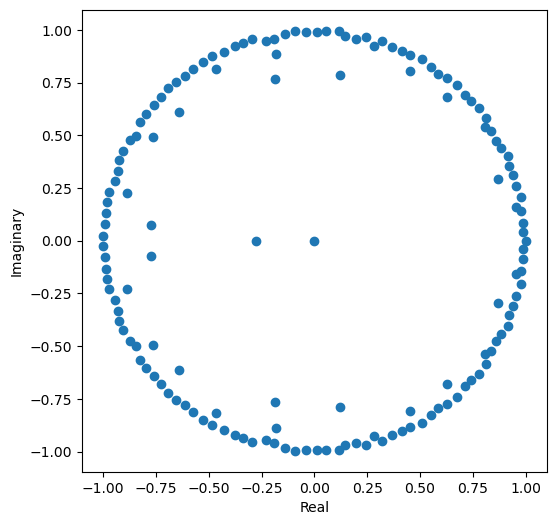

In [26]:
plt.figure(figsize=(6,6))
plt.scatter(eigenvals.real, eigenvals.imag)
plt.xlabel('Real',)
plt.ylabel('Imaginary')
plt.show()

<ol style="list-style-type: lower-alpha" start="5">
<li>
Use this <b>A</b> matrix to advance the state 
<b>w</b><sub><i>k</i></sub> = A<sup><i>k</i>-1</sup><b>w</b><sub>1</sub> starting from <b>w</b><sub>1</sub>. Plot the reconstructed flow field using these predicted amplitude vectors and compare with the true values.
</li>
</ol>

Source: <i>Brunton, S., & Kutz, J. (2022). Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control (2nd ed.). Cambridge: Cambridge University Press. (doi:10.1017/9781009089517)</i>

The error bentween the column 0 from the original and reconstructed matrices: 0.0%
The error bentween the column 10 from the original and reconstructed matrices: 0.0%
The error bentween the column 30 from the original and reconstructed matrices: 0.0%
The error bentween the column 60 from the original and reconstructed matrices: 0.0%
The error bentween the column 115 from the original and reconstructed matrices: 0.0%


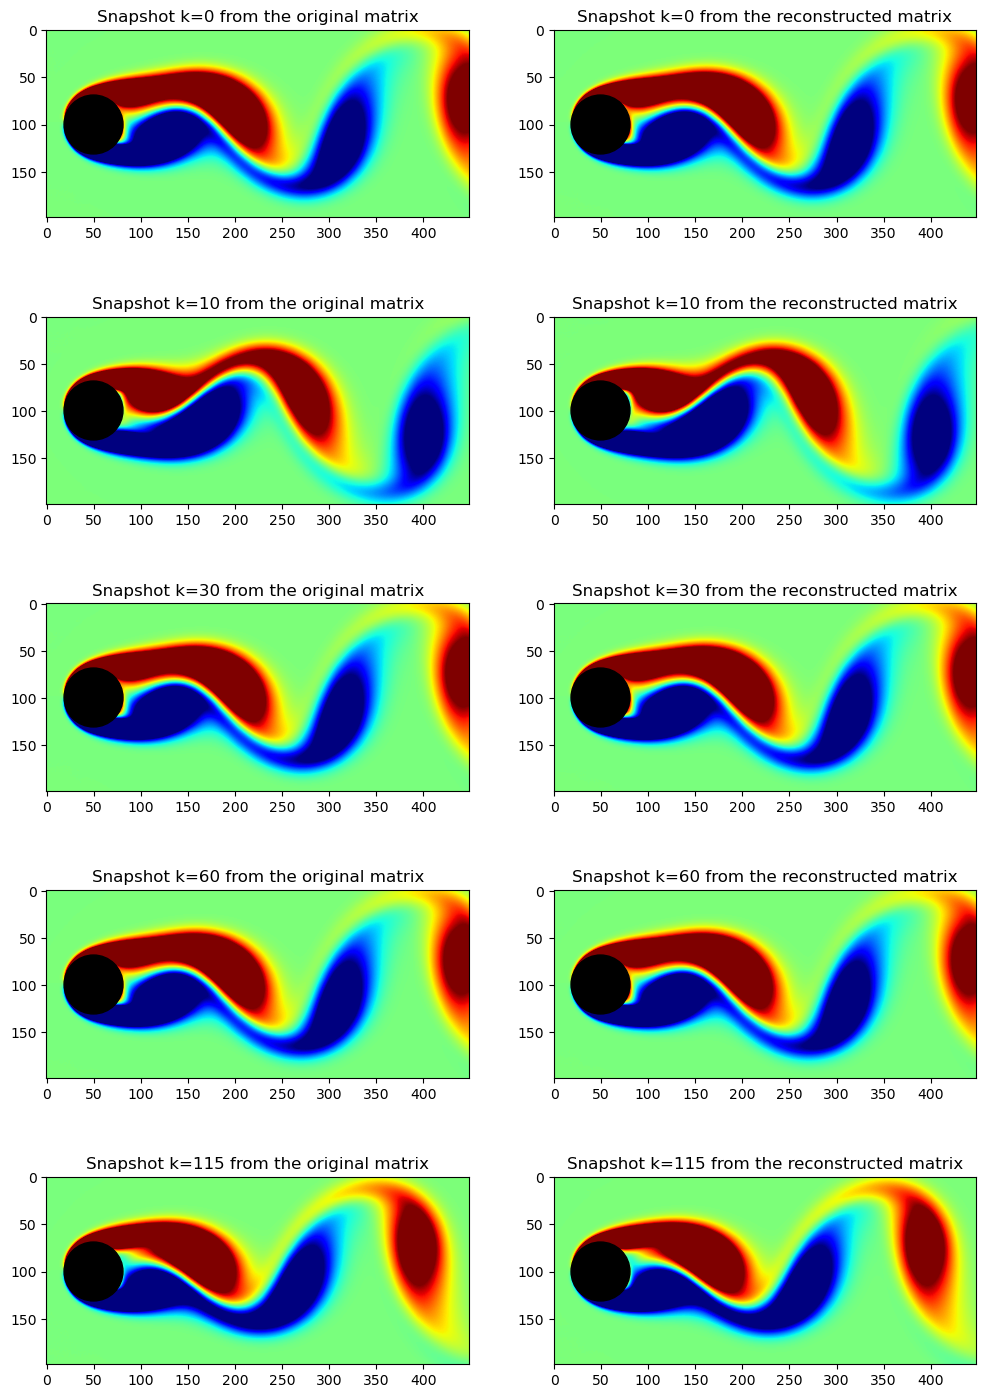

In [112]:
fig, ax = plt.subplots(5,2,figsize=(12, 18))
for i, k in enumerate([1,11,31,61,116]):
    x_k = np.real(np.reshape(X[:,k-1],(449,199)))
    x_k = x_k.T
    
    w_k = np.linalg.matrix_power(A,k-1) @ W[0:,0]
    x_k_rec = Ue @ w_k
    x_k_rec = np.real(np.reshape(x_k_rec,(449,199)))
    x_k_rec = x_k_rec.T
    
    err = error(x_k,x_k_rec)
    print(f'The error bentween the column {k-1} from the original and reconstructed matrices: {err}%')
    
    ax[i][0].imshow(x_k,cmap='jet',vmin=-1,vmax=1)
    ax[i][0].scatter(49,99,1800,color='k')
    ax[i][0].set_title(f'Snapshot k={k-1} from the original matrix')
    ax[i][1].imshow(x_k_rec,cmap='jet',vmin=-1,vmax=1)
    ax[i][1].scatter(49,99,1800,color='k')
    ax[i][1].set_title(f'Snapshot k={k-1} from the reconstructed matrix')